### Using averagine modeled reference patterns for charge state deconvolution

Translating slices of mass spectra into a set of representative keys is not limited to self-similarity detection. Other approaches used LSH for fast candidate identification of fragment-spectra, see for example Wang et al.[^1][^2]. Here, a look-up database is built by first mapping all reference sepctra into LSH-key representations. Using LSH first, unidentified candidate spectra only need to be matched with a subset of candidates in the database, greatly reducing the total number of comparisons. For a more detailed explanation of algorithmic solutions to spectral identification in general, the interested reader is refered to Edward M. Marcotte[^3].

We built on the idea of a pre-computed reference, but used typical isotope patterns to find peptide ions of a specific charge state in precursor spectra instead. These are hashed to form a reference database, which can then be used to detect isotope patterns in sets of spectrum windows directly. This approach is of course more restrictive when it comes to the space of allowed signal shapes, as it requires a window to be similar to one of the modeled peak distributions.

The averagine model as proposed by Senko et al.[^4] was used to create all reference patterns:

\begin{equation}
I(x \rvert m, z, \sigma) = \sum_{k=0}^{K} w(m, k) \, \mathcal{N}\left(x \bigg| \frac{m + k\mathrm{m_n}}{z}, \sigma^{2} \right)
\end{equation}

\begin{equation}
w(m,k) = \mathrm{e}^{-\lambda(m)}\frac{\lambda^k(m)}{\Gamma(k+1)}
\end{equation}

\begin{equation}
\lambda(m) = \beta m + \gamma
\end{equation}

where $x$ denotes position on the $m/z$ axis, $m$ the mass of the molecule, $z$ the charge state of the molecule, $\sigma$ the width of the peak, $\mathcal{N}$ probability density function of the Gaussian distribution, $\mathrm{m_n}$ mass of the neutron, $\Gamma$ the gamma function, $\beta$ = $-3.091 \cdot 10^{-2}$ and $\gamma = 5.94 \cdot 10^{-4} \mathrm{Da}^{-1}$. 

It was sampled with a step size of $10^{-5}$ in a range from $-1$ to $+9$ Da around the monoisotopic peak and afterwards binned to a resolution of $10^{-2}$ Da. This was done for all masses from 150 to 1800 Da and for all charge states from 1 to 5.

We then applied our hashing strategy to those synthetical mass spectra the same way it was applied to self-similarity detection. When an unidentified window is now hashed, its key-set can be used to select a set of candidate isotope-patterns, for which cosine similarity is calculated explicitely. Should a certain threshold of similarity be surpassed, the highest scoring reference pattern is returned together with its charge state and monoisotopic mass.

---
[^1]: msCRUSH: Fast Tandem Mass Spectral Clustering Using Locality Sensitive Hashing.
journal of proteome, 2019. https://pubs.acs.org/doi/10.1021/acs.jproteome.8b00448

[^2]: A Fast and Memory-Efficient Spectral Library Search Algorithm Using Locality-Sensitive Hashing. 
Proteomics, 2020.  https://doi.org/10.1002/pmic.202000002

[^3]: How do shotgun proteomics algorithms identify proteins?
nature biotechnology, 2007. https://doi.org/10.1038/nbt0707-755

[^4]: Senko et al.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import time
from tqdm.notebook import tqdm

from proteolizarddata.data import PyTimsDataHandle, TimsFrame, MzSpectrum
from proteolizardalgo.hashing import TimsHasher, IsotopeReferenceSearch, ReferencePattern
from proteolizardalgo.utility import create_reference_dict, get_refspec_list, get_ref_pattern_as_spectra

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KDTree

In [2]:
dh = PyTimsDataHandle('../data/M210115_001_Slot1-1_1_850.d/')

In [3]:
ref_hashes = pd.read_parquet('synthetic_patterns_last_contrib.parquet')
d_list = get_refspec_list(get_ref_pattern_as_spectra(ref_hashes), win_len=4)
d = create_reference_dict(d_list)

creating reference patterns: 100%|███████████████████████████| 17857/17857 [02:07<00:00, 140.39it/s]


In [6]:
hasher = TimsHasher(trials=512, len_trial=22, seed=42, num_dalton=4, resolution=2)

In [ ]:
ref_search = IsotopeReferenceSearch(d, hasher=hasher)

calculating keys:  88%|██████████████████████████████████████     | 344/389 [00:18<00:02, 19.77it/s]

In [ ]:
dda_precursors = dh.get_selected_precursors()
all_parent_ids = sorted(list(set(dda_precursors.Parent)))

In [7]:
1918

1918

In [8]:
t_list = []

for i in tqdm(all_parent_ids[8 * 50:]):

    random_id = i
    
    try:
        frame = dh.get_frame(random_id)
        patterns = ref_search.find_isotope_patterns(frame, min_intensity=100, min_peaks=4, overlapping=True)

        prec = dda_precursors[dda_precursors.Parent == random_id].sort_values('MonoisotopicMz').dropna()
        prec['MonoisotopicMz'] = np.round(prec['MonoisotopicMz'], 2)
        prec['ScanNumber'] = np.round(prec['ScanNumber'])

        kdt = KDTree(patterns[['scan', 'charge', 'mz_mono']].values, leaf_size=30, metric='euclidean')
        distance, index = kdt.query(prec[['ScanNumber', 'Charge', 'MonoisotopicMz']].values)

        matched = pd.DataFrame(np.hstack((np.squeeze(patterns[['scan', 'charge', 'mz_mono']].values[index]), 
                                prec[['MonoisotopicMz', 'ScanNumber', 'Charge']].values, distance)), 

                               columns=['scan', 'charge', 'mz_mono', 
                 'MonoisotopicMz', 'ScanNumber', 'Charge', 'distance']).sort_values(['distance'])

        matched['mz_diff'] = np.round(np.abs(matched['mz_mono'] - matched['MonoisotopicMz']), 2)

        t_list.append(matched)
        
    except Exception as e:
        print(e)
        pass

  0%|          | 0/5381 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
alle = pd.concat(t_list).sort_values(['charge', 'mz_diff'])

alle['mz-diff-mod-1.0'] = alle['mz_diff'] % 1

alle = alle.sort_values(['mz_diff'])

In [ ]:
alle

In [ ]:
# alle.to_parquet('OUT-matched2.parquet', index=False)

In [11]:
alle[alle['mz_diff'] <= 4].sort_values(['mz_diff']).shape

(61, 9)

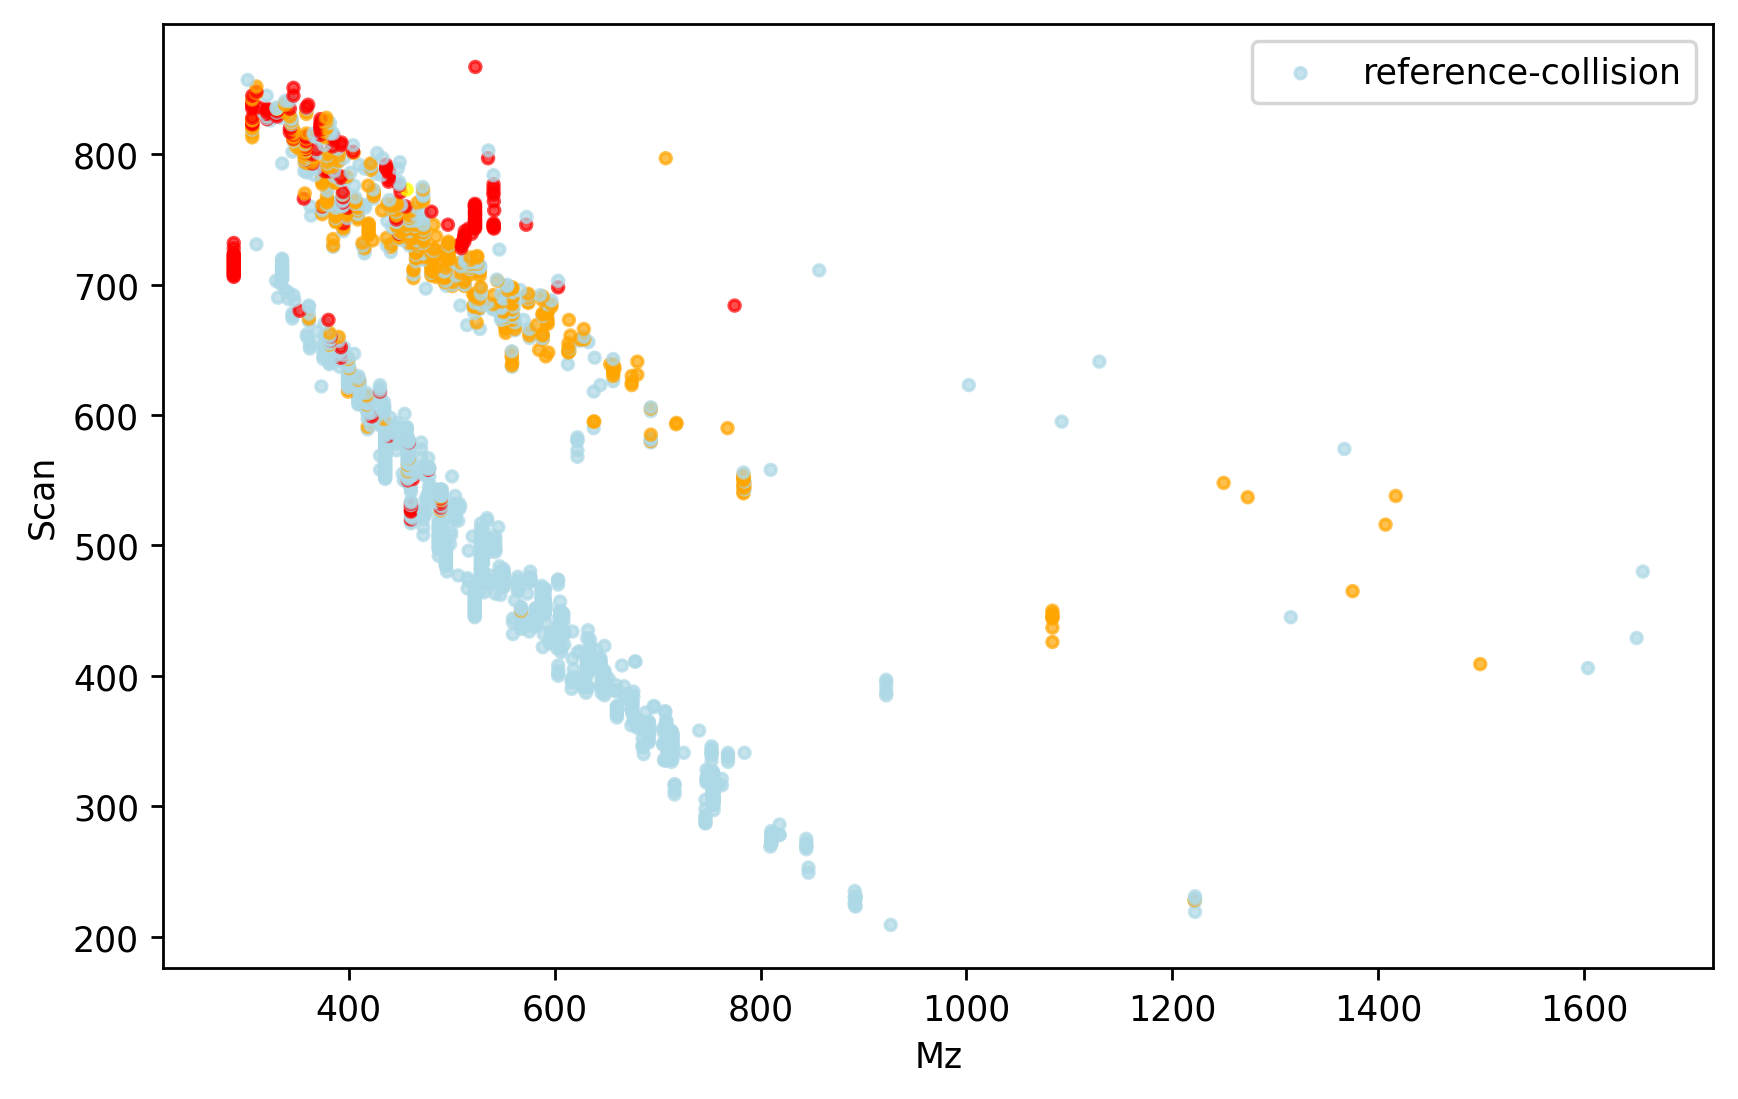

In [13]:
plt.figure(figsize=(8, 5), dpi=250)
plt.xlabel('Mz')
plt.ylabel('Scan')
# plt.scatter(np.abs(c_bin) * 4, c_scan, alpha=.5, s=15, color='darkblue', label='self-collision')
plt.scatter(patterns.mz_mono, patterns.scan, color=[color_dict[c] for c in patterns.charge], 
            alpha=.7, s=10, label='reference-collision', edgecolors=None)
#plt.scatter(v.AverageMz, v.ScanNumber, color=[color_dict[c] for c in v.Charge], 
#            marker='X', edgecolors='black', s=75, label='DDA-fragmeted', alpha=.75)
plt.legend()
plt.show()

In [ ]:
# alle.to_parquet('ref-search-results.pq', index=False)

### Results